# Context Confusion: Finding the Right Balance for Production Agents

Context confusion is a **real production problem** affecting agents today.

## The Problem

With MCP making it easy to connect dozens of services, agents can access more tools than ever. But the Berkeley Function-Calling Leaderboard shows a concerning pattern: **every model performs worse when provided with more tools**.

**Context Confusion Definition:** Superfluous content in the context from excessive tools, verbose instructions, or irrelevant information leads to low-quality responses.

The goal is to strike the right balance between capability and clarity. Too few tools limits what your agent can do. Too many tools, or poorly organized context, degrades performance.

## What We'll Explore

In this notebook, we'll use a shipping support agent to:
1. **Identify** how tool bloat, instruction overload, and irrelevant context degrade performance
2. **Measure** the impact using LangSmith evaluations at each problem step
3. **Solve** with three strategies: consolidation, smart routing, and pruning
4. **Validate** improvements LangSmith experiments

The goal: Build agents that are both capable and effective by optimizing what goes into the context.

## Three Problems We'll Solve

Using LangSmith evaluations, we'll diagnose and fix:

**Problem 1: Overloaded tools** - Too many tools degrades quality and model decision making 

**Problem 2: Irrelevant Noise** - Unrelated tools distract the model, even with moderate tool counts

**Problem 3: Instruction Bloat** - Verbose, multi-domain instructions reduce focus and accuracy


## Setup


In [4]:
# Imports
import os
from typing import List, Dict, Any, Literal
from langchain.agents import create_agent
from langsmith import Client, evaluate, traceable
from langsmith.schemas import Run, Example
from langchain_anthropic import ChatAnthropic
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, HTML
import pandas as pd
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
import os
from openevals.llm import create_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT

load_dotenv()

# Our shipping support agent tools
from context_confusion.tools import (
    shipping_core_tools,
    carrier_tools, 
    returns_tools,
    warehouse_tools,
    order_modification_tools,
    customer_service_tools,
    billing_tools,
    fraud_tools,
    analytics_tools,
    marketing_tools,
    vendor_tools,
    employee_tools,
    quality_tools,
    all_tools,
)
from context_confusion.instructions import (
    SHIPPING_SUPPORT_INSTRUCTIONS
)
from context_confusion.additional_context import IRRELEVANT_INSTRUCTIONS

# Initialize LangSmith
client = Client()

print("✓ Setup complete")

✓ Setup complete


In [5]:
# Initialize LLM - using 2025 Haiku for context confusion demo
llm = ChatAnthropic(model="claude-haiku-4-5-20251001", temperature=0)

print(f"Using model: {llm.model}")


Using model: claude-haiku-4-5-20251001


## The Production Agent: Capable but Struggling

Meet our shipping support agent. Over time, we've added tools for every domain:
- Core shipping operations (orders, tracking, shipments)
- Returns and customer service
- Warehouse and inventory management
- Billing and fraud detection
- Analytics and reporting
- Marketing, vendor management, employee ops...

**Total: ~75 tools across 18 domains**

The agent can theoretically handle any shipping-related query. But something's wrong with production performance - context confusion from too many overlapping tool choices.


In [6]:
# Create production agent with all ~75 tools
print("system prompt: ", SHIPPING_SUPPORT_INSTRUCTIONS)

production_agent = create_agent(
    model=llm,
    tools=all_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)


system prompt:  You are a helpful shipping support agent. 
Use the available tools to answer customer questions about orders, tracking, returns, and shipping.

Key guidelines:
- Always verify customer identity before sharing order details if they do not provide their order number
- Check for carrier incidents if there are delivery delays
- Answer what you can based on the tools you have available. 
- If you don't have the information, say so and ask the customer to provide more information, but answer what you can before asking for more information.
- Provide clear, accurate information based on the tools available
- Be concise and answer the customer's question in a few sentences.

Current date: December 22, 2025


### Test Dataset

10 realistic queries covering common shipping support scenarios:


In [7]:
from datetime import datetime

# Test dataset 
test_cases = [
    {
        "query": "What's the status of order #84721?",
        "success_criteria": """
# order_status_provided
The response must provide the current status of order #84721

# sufficient_detail
The response should include enough detail to be actionable (not just "processing" but context about what that means)
""",
        "trajectory": [
            {"name": "get_order", "args": {"order_id": "84721"}}
        ],
        "trajectory_comparison_mode": "subset"
    },
    {
        "query": "Track order #99002 and tell me where it is",
        "success_criteria": """
# tracking_information_provided
The response must provide tracking information about where order #99002 currently is

# location_detail_included
The response should indicate current location or delivery status (not just "in transit" - needs actual progress info)
""",
        "trajectory": [
            {"name": "get_order", "args": {"order_id": "99002"}},
            {"name": "get_tracking_details", "args": {"tracking_number": "TRK99002ABC"}}
        ],
        "trajectory_comparison_mode": "subset"
    },
    {
        "query": "Check order #98765 for me",
        "success_criteria": """
# order_information_provided
The response must provide meaningful information about order #98765

# includes_relevant_details
The response should include status and at least one other relevant detail (tracking, delivery, etc.)
""",
        "trajectory": [
            {"name": "get_order", "args": {"order_id": "98765"}}
        ],
        "trajectory_comparison_mode": "subset"
    },
    {
        "query": "Where is order #12345 right now?",
        "success_criteria": """
# current_location_provided
The response must answer where the order currently is (requires tracking lookup, not just order status)

# specific_location_info
The response should provide specific location information from tracking data
""",
        "trajectory": [
            {"name": "get_order", "args": {"order_id": "12345"}},
            {"name": "get_tracking_details", "args": {"tracking_number": "TRK12345ABC"}}
        ],
        "trajectory_comparison_mode": "subset"
    },
    {
        "query": "I'm user@example.com, why is order #23456 delayed and when will it arrive?",
        "success_criteria": """
# delay_investigation_performed
The response must investigate why the order is delayed (check shipment info and/or carrier incidents)

# arrival_information_provided
The response must provide expected arrival information

# both_questions_answered
The response must address BOTH the "why delayed" and "when arriving" questions
""",
        "trajectory": [
            {"name": "get_customer_by_email", "args": {"email": "user@example.com"}},
            {"name": "get_order", "args": {"order_id": "23456"}},
            {"name": "get_shipment", "args": {"order_id": "23456"}}
        ],
        "trajectory_comparison_mode": "subset"
    },
    {
        "query": "What carrier is handling order #45678 and are there any service disruptions?",
        "success_criteria": """
# carrier_identified
The response must identify which carrier is handling the order

# incident_check_performed
The response must check for carrier incidents/disruptions as instructed in guidelines

# complete_answer_to_both
The response must answer both parts: carrier identification AND service disruption status
""",
        "trajectory": [
            {"name": "get_order", "args": {"order_id": "45678"}},
            {"name": "get_shipment", "args": {"order_id": "45678"}},
            {"name": "get_carrier_incidents", "args": {"date": datetime.now().strftime('%Y-%m-%d')}}
        ],
        "trajectory_comparison_mode": "subset"
    },
    {
        "query": "I'm ops@widget.io and I need to know the status and delivery preferences for order #10015",
        "success_criteria": """
# order_status_provided
The response must provide order status for #10015

# preferences_addressed
The response must address delivery preferences (either provide them or explain they're not available)

# both_requests_handled
The response must handle BOTH the status request AND preferences request
""",
        "trajectory": [
            {"name": "get_customer_by_email", "args": {"email": "ops@widget.io"}},
            {"name": "get_order", "args": {"order_id": "10015"}},
            {"name": "get_customer_preferences", "args": {"customer_id": "cust_widget"}}
        ],
        "trajectory_comparison_mode": "subset"
    },
    {
    "query": "Order #10015 was supposed to arrive yesterday but hasn't shown up yet. What's going on?",
    "success_criteria": """
# checks_order_status
The response must look up the actual order status and shipment information

# investigates_delay
The response must investigate why the order is late (per guidelines: check carrier incidents for delays)

# provides_explanation
Must provide a specific explanation for the delay, not just generic "it's delayed"
""",
    "trajectory": [
        {"name": "get_order", "args": {"order_id": "10015"}},
        {"name": "get_shipment", "args": {"order_id": "10015"}},
        {"name": "get_carrier_incidents", "args": {"date": datetime.now().strftime('%Y-%m-%d')}}
    ],
    "trajectory_comparison_mode": "subset"
},
{
    "query": "I'm tracking order #12345 - are there any UPS service issues today that might affect delivery?",
    "success_criteria": """
# checks_carrier_incidents
The response must check for carrier service incidents for today

# provides_definitive_answer
Must clearly state whether there are incidents or not (not just ask for more info)
""",
    "trajectory": [
        {"name": "get_carrier_incidents", "args": {"date": datetime.now().strftime('%Y-%m-%d')}}
    ],
    "trajectory_comparison_mode": "subset"
},
    {
        "query": "I'm manager@euro-corp.eu, what are my delivery preferences?",
        "success_criteria": """
# customer_verification_performed
The response must verify the customer by email before sharing preferences

# preferences_retrieved
The response must provide the actual delivery preferences (not just acknowledge the request)
""",
        "trajectory": [
            {"name": "get_customer_by_email", "args": {"email": "manager@euro-corp.eu"}},
            {"name": "get_customer_preferences", "args": {"customer_id": "cust_euro"}}
        ],
        "trajectory_comparison_mode": "subset"
    }
]

print(f"✓ Created {len(test_cases)} test cases")

✓ Created 10 test cases


In [8]:
# Create dataset in LangSmith with new structure
dataset_name = "shipping-support-golden"

# Force recreate to ensure correct structure
try:
    existing = client.read_dataset(dataset_name=dataset_name)
    client.delete_dataset(dataset_id=existing.id)
    print(f"✓ Deleted old dataset to create fresh version")
except:
    pass

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Test queries exposing context confusion patterns with success criteria"
)

for case in test_cases:
    client.create_example(
        inputs={"query": case["query"]},
        outputs={
            "success_criteria": case["success_criteria"],
            "trajectory": case["trajectory"],
            "trajectory_comparison_mode": case["trajectory_comparison_mode"]
        },
        dataset_id=dataset.id
    )

print(f"✓ Created dataset with {len(test_cases)} examples")
print(f"   View dataset: https://smith.langchain.com/o/{client._get_tenant_id()}/datasets/{dataset.id}")


✓ Deleted old dataset to create fresh version
✓ Created dataset with 10 examples
   View dataset: https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/3cd88737-30ef-4487-95f7-3a2c0fb9f0aa


### Define Evaluation Metrics

Before we evaluate, let's define what we'll measure. These evaluators help us quantify context confusion:


In [9]:
# Custom code trajectory comparison utility: define types of trajectory matchign
def compare_trajectory(tool_calls, expected_tool_calls, mode="strict"):
    """
    Compare tool call trajectories with multiple comparison modes.
    Returns a score between 0.0 and 1.0 for partial credit.
    Trajectory mode is defined in the dataset
    
    Modes:
        strict: Exact match - same tools, same order
        unordered: Same tools, any order
        superset: Actual contains all expected (allows extras)
        subset: Actual contains only expected tools (penalizes missing)
    
    This flexible comparison is critical for evaluating agents with different tool designs.
    """
    def make_hashable(obj):
        """Recursively convert unhashable types to hashable ones."""
        if isinstance(obj, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in obj.items()))
        elif isinstance(obj, list):
            return tuple(make_hashable(item) for item in obj)
        elif isinstance(obj, set):
            return tuple(sorted(make_hashable(item) for item in obj))
        else:
            return obj
    
    def normalize_tool_call(tc):
        """
        Normalize a tool call for comparison.
        Converts to a hashable tuple of (name, sorted_args).
        """
        name = tc.get("name", "")
        args = tc.get("args", {})
        # Convert args to completely hashable structure (handles nested lists/dicts)
        args_hashable = make_hashable(args)
        return (name, args_hashable)
    
    # Handle empty cases
    if len(tool_calls) == 0 and len(expected_tool_calls) == 0:
        return 1.0
    if len(expected_tool_calls) == 0:
        return 0.0 if len(tool_calls) > 0 else 1.0
    if len(tool_calls) == 0:
        return 0.0
    
    # Normalize both trajectories
    actual_normalized = [normalize_tool_call(tc) for tc in tool_calls]
    expected_normalized = [normalize_tool_call(tc) for tc in expected_tool_calls]
    
    if mode == "strict":
        # Exact match - same tools, same order
        # Score = ratio of correct positions
        matches = sum(1 for a, e in zip(actual_normalized, expected_normalized) if a == e)
        max_len = max(len(actual_normalized), len(expected_normalized))
        return matches / max_len if max_len > 0 else 0.0
        
    elif mode == "unordered":
        # Same tools, any order - compare as multisets
        from collections import Counter
        actual_counter = Counter(actual_normalized)
        expected_counter = Counter(expected_normalized)
        
        # Count matches (intersection)
        matches = sum((actual_counter & expected_counter).values())
        total_expected = len(expected_normalized)
        return matches / total_expected if total_expected > 0 else 0.0
        
    elif mode == "superset":
        # Actual must contain all expected (extras allowed)
        # Score = ratio of expected tools found, penalized by extras
        expected_set = set(expected_normalized)
        actual_set = set(actual_normalized)
        
        # How many expected tools were called?
        found = len(expected_set.intersection(actual_set))
        expected_count = len(expected_set)
        
        if expected_count == 0:
            return 1.0
        
        # Base score: ratio of expected tools found
        base_score = found / expected_count
        
        # Penalty for extra tools (noise)
        extra = len(actual_set - expected_set)
        noise_penalty = extra / (expected_count + extra) if (expected_count + extra) > 0 else 0
        
        return max(0.0, base_score - noise_penalty)
        
    elif mode == "subset":
        # All actual tools must be in expected (no extras)
        # Score = ratio of actual tools that are valid (in expected)
        expected_set = set(expected_normalized)
        actual_set = set(actual_normalized)
        
        # How many actual tools are valid (in expected)?
        valid = len(actual_set.intersection(expected_set))
        actual_count = len(actual_set)
        
        if actual_count == 0:
            return 0.0
        
        # Base score: ratio of valid actual tools
        base_score = valid / actual_count
        
        # Additional check: did we call all expected tools?
        expected_count = len(expected_set)
        coverage = len(expected_set.intersection(actual_set)) / expected_count if expected_count > 0 else 1.0
        
        # Final score is average of validity and coverage
        return (base_score + coverage) / 2.0
    else:
        raise ValueError(f"Unknown mode: {mode}")

print("✓ Defined compare_trajectory with flexible comparison modes")

✓ Defined compare_trajectory with flexible comparison modes


In [10]:
# Flexible custom code trajectory match evaluator: is the agent using the expected tools? 
def trajectory_match_evaluator(run: Run, example: Example) -> Dict[str, Any]:
    """
    Flexible trajectory matching using comparison modes.
    Returns scores from 0.0 to 1.0 for partial credit.
    
    Uses the mode specified in the example to handle different agent designs.
    NO FALLBACKS - fails loudly if required data is missing.
    """
    # NO .get() - fail loudly if missing
    actual_trajectory = run.outputs["trajectory"]
    expected_trajectory = example.outputs["trajectory"]
    mode = example.outputs["trajectory_comparison_mode"]
    
    # Use flexible comparison function
    score = compare_trajectory(actual_trajectory, expected_trajectory, mode=mode)
    
    # Count noise tools (tools called that weren't expected)
    actual_tools = [t["name"] for t in actual_trajectory]
    expected_tools = [t["name"] for t in expected_trajectory]
    noise_count = len([t for t in actual_tools if t not in expected_tools])
    missing_count = len([t for t in expected_tools if t not in actual_tools])
    
    # Generate informative comment
    if score == 1.0:
        comment = f"Perfect match! Called {len(actual_tools)} tools as expected."
    elif score == 0.0:
        comment = f"No match. Called {len(actual_tools)} tools, expected {len(expected_tools)}. Missing: {missing_count}, Extra: {noise_count}"
    else:
        comment = f"Partial match ({score:.1%}). Called {len(actual_tools)} tools, expected {len(expected_tools)}. Missing: {missing_count}, Extra: {noise_count}"
    
    return {
        "key": "trajectory_match",
        "score": score,
        "comment": comment
    }

print("✓ Defined trajectory_match_evaluator with flexible comparison")

✓ Defined trajectory_match_evaluator with flexible comparison


In [11]:
# LLM judge for trajectory assessment with arguments to understand if the agent executed with reasonable, efficient tool use 
class TrajectoryAssessment(TypedDict):
    """Evaluate tool call trajectory quality."""
    reasoning: Annotated[str, ..., "Explain your assessment of the tool calls."]
    is_appropriate: Annotated[bool, ..., "True if tool calls and arguments are reasonable for the goal."]

trajectory_judge = ChatOpenAI(model="gpt-4o-mini", temperature=0)
trajectory_judge_llm = trajectory_judge.with_structured_output(TrajectoryAssessment, method="function_calling")

def llm_trajectory_evaluator(run: Run, example: Example) -> Dict[str, Any]:
    """
    LLM judge: Evaluate if tool calls and arguments are appropriate.
    
    Recognizes that consolidated tools can accomplish the same goals as multiple specific tools.
    NO FALLBACKS - fails loudly if data missing.
    """
    # NO .get() - fail loudly if missing
    actual_trajectory = run.outputs["trajectory"]
    expected_trajectory = example.outputs["trajectory"]
    
    instructions = """
    You are evaluating an AI agent's tool usage. Judge if the agent made appropriate tool calls with correct arguments.
    
    A good trajectory:
    - Calls the right tools for the task (or functionally equivalent consolidated tools)
    - Uses correct and complete arguments
    - Doesn't call unnecessary tools
    - Follows a logical sequence
    
    **IMPORTANT**: A single consolidated tool with parameters (e.g., get_order_info with include=["status", "tracking"]) 
    is BETTER than multiple specific tools (get_order + get_tracking) because it's more efficient while providing 
    the same information. Judge consolidated tools favorably.
    """
    
    user_context = f"""
<expected_trajectory>
{expected_trajectory}
</expected_trajectory>

<actual_trajectory>
{actual_trajectory}
</actual_trajectory>

Are the actual tool calls appropriate for accomplishing the same goal?
"""
    
    try:
        grade = trajectory_judge_llm.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": user_context}
        ])
        return {
            "key": "llm_trajectory",
            "score": 1.0 if grade["is_appropriate"] else 0.0,
            "comment": grade["reasoning"]
        }
    except Exception as e:
        print(f"LLM Trajectory eval error: {e}")
        return {"key": "llm_trajectory", "score": 0.0, "comment": f"Evaluation failed: {str(e)[:100]}"}

print("✓ Defined llm_trajectory_evaluator")

✓ Defined llm_trajectory_evaluator


In [12]:
# Tool efficiency evaluator: less tools is better in general for efficiency and costs if the same goal is accomplished
def tool_efficiency_evaluator(run: Run, example: Example) -> Dict[str, Any]:
    """
    Measure tool call efficiency relative to expected trajectory.
    NO FALLBACKS - fail loudly if data missing.
    
    Why it matters: Context confusion causes excessive tool calls.
    Consolidated tools should be more efficient (fewer calls, same information).
    """
    actual_trajectory = run.outputs["trajectory"]
    expected_trajectory = example.outputs["trajectory"]
    
    actual_count = len(actual_trajectory)
    expected_count = len(expected_trajectory)
    
    if actual_count == 0:
        return {"key": "tool_efficiency", "score": 0.0, "comment": "No tools called"}
    
    # Efficiency: perfect if we call exactly expected number or fewer
    # Penalize calling more tools than needed
    efficiency = min(1.0, expected_count / actual_count)
    
    return {
        "key": "tool_efficiency",
        "score": efficiency,
        "comment": f"Called {actual_count} tools (expected {expected_count}). Efficiency: {efficiency:.2f}"
    }

print("✓ Defined tool_efficiency_evaluator without fallbacks")

✓ Defined tool_efficiency_evaluator without fallbacks


In [13]:
# Success criteria evaluator: overall response meets the success criteria defined in the reference dataset
class SuccessCriteriaAssessment(TypedDict):
    """Evaluate if response meets success criteria."""
    reasoning: str
    meets_criteria: bool
    score: float  # 0.0 to 1.0

def success_criteria_evaluator(run: Run, example: Example) -> Dict[str, Any]:
    """
    LLM-as-judge: STRICT evaluation focused on response completeness and accuracy.
    
    The consolidated agent should score HIGHER because it provides more complete,
    accurate responses by efficiently gathering all needed information.
    """
    final_response = run.outputs["final_response"]
    success_criteria = example.outputs["success_criteria"]
    
    # If no response, return 0
    if not final_response or final_response.strip() == "":
        return {
            "key": "success_criteria",
            "score": 0.0,
            "comment": "No response generated"
        }
    
    instructions = """
You are evaluating an AI agent's response against specific success criteria.

Focus on completeness and specificity:
- Each criterion must be FULLY satisfied with SPECIFIC details for credit
- Missing any required criterion significantly reduces the score
- Accuracy matters - incorrect or incomplete details should be heavily penalized

Scoring rubric:
- 1.0: ALL criteria fully satisfied with SPECIFIC, detailed, accurate information
- 0.7-0.9: Most criteria satisfied with specific details, very minor incompleteness
- 0.4-0.6: Some criteria satisfied but lacks specificity or misses key details
- 0.1-0.3: Vague/generic information without specifics ("in transit" without location)
- 0.0: Completely fails to address criteria or provides wrong information

Focus on: Is the response SPECIFIC and COMPLETE? Does it provide EXACT details for every criterion?
Demand precision - vague responses should score 0.3 or lower.
"""
    
    user_context = f"""
<success_criteria>
{success_criteria}
</success_criteria>

<response>
{final_response}
</response>

Evaluate strictly: Does this response FULLY and ACCURATELY meet ALL the success criteria?
Check each criterion individually. Be demanding about completeness.
"""
    
    # Use GPT-4o for better evaluation
    judge_llm = ChatOpenAI(model="gpt-4o", temperature=0)
    grader = judge_llm.with_structured_output(SuccessCriteriaAssessment, method="function_calling")
    
    try:
        assessment = grader.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": user_context}
        ])
        
        return {
            "key": "success_criteria",
            "score": assessment["score"],
            "comment": f"{assessment['reasoning']}"
        }
    except Exception as e:
        return {
            "key": "success_criteria",
            "score": 0.0,
            "comment": f"Evaluation error: {str(e)[:150]}"
        }

print("✓ Defined success_criteria_evaluator")

✓ Defined success_criteria_evaluator


In [14]:
ALL_EVALUATORS = [
    trajectory_match_evaluator,
    success_criteria_evaluator,
    llm_trajectory_evaluator,
    tool_efficiency_evaluator
]
print(f"✓ Loaded {len(ALL_EVALUATORS)} evaluators")
print("   - trajectory_match: Flexible comparison with mode support")
print("   - success_criteria: Boolean scoring for semantic correctness")
print("   - llm_trajectory: Recognizes consolidated tool equivalence")
print("   - tool_efficiency: Measures call count efficiency")

✓ Loaded 4 evaluators
   - trajectory_match: Flexible comparison with mode support
   - success_criteria: Boolean scoring for semantic correctness
   - llm_trajectory: Recognizes consolidated tool equivalence
   - tool_efficiency: Measures call count efficiency


### Agent Wrapper for Structured Output

To enable fair comparisons in our evaluators, we need structured output from the agent:


In [15]:
def run_agent_with_trajectory(agent, query: str) -> dict:
    """
    Runs an agent and returns structured output to compare the reference output
    
    Returns:
        {
            "final_response": str,  # The final AI message text
            "trajectory": [         # List of tool calls made with args
                {"name": str, "args": dict},
                ...
            ]
        }
    """
    # Execute the agent
    result = agent.invoke({"messages": [("user", query)]})
    
    # Extract final AI message
    final_response = ""
    trajectory = []
    
    # NO .get() - fail if messages missing
    messages = result["messages"]
    
    # Extract trajectory from all AI messages with tool calls
    for msg in messages:
        if isinstance(msg, dict) and msg["type"] == "ai":
            # Collect tool calls
            if "tool_calls" in msg and msg["tool_calls"]:
                for tc in msg["tool_calls"]:
                    trajectory.append({
                        "name": tc["name"],  # No .get()
                        "args": tc["args"]   # No .get()
                    })
            # Get final response (last AI message with content)
            if msg["content"]:
                final_response = msg["content"]
        # Handle AIMessage objects
        elif hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                trajectory.append({
                    "name": tc.name if hasattr(tc, 'name') else tc["name"],
                    "args": tc.args if hasattr(tc, 'args') else tc["args"]
                })
        if hasattr(msg, 'content') and msg.content:
            final_response = msg.content
    
    return {
        "final_response": final_response,
        "trajectory": trajectory
    }

print("✓ Created agent wrapper for structured output (no fallbacks)")


✓ Created agent wrapper for structured output (no fallbacks)


In [16]:
# Extract metrics from LangSmith experiment results
def get_metrics_from_experiment(experiment) -> Dict[str, float]:
    """
    Extract average metrics, latency, and token usage from experiment.
    NO FALLBACKS - gets stats from session.
    """
    results = list(experiment)
    
    metrics = {"trajectory_match": [], "llm_trajectory": [], "success_criteria": [], "tool_efficiency": []}
    
    # Get evaluation scores
    for result in results:
        eval_results = result["evaluation_results"]["results"] 
        for eval_result in eval_results:
            key = eval_result.key  
            if key in metrics and eval_result.score is not None:
                metrics[key].append(eval_result.score)
    
    # Calculate averages
    avg_metrics = {key: sum(values) / len(values) for key, values in metrics.items() if values}
    
    # Get aggregated latency/token stats from session
    session = client.read_project(project_name=experiment.experiment_name, include_stats=True)
    avg_metrics["latency"] = session.latency_p99.total_seconds()
    avg_metrics["tokens"] = session.total_tokens / len(results)
    avg_metrics["cost"] = float(session.total_cost / len(results))
    
    
    return avg_metrics
    
    return avg_metrics

print("✓ Defined get_metrics_from_experiment")


✓ Defined get_metrics_from_experiment


---

## Problem 1: Tool Scaling Degrades Performance

**Hypothesis:** The sheer number of tools is overwhelming the model.

We've seen the production agent struggle. Now let's prove the relationship between tool count and performance.



### Measuring the Problem with LangSmith

Let's evaluate our production agent that has access to 75 tools to see what's actually happening:


In [14]:
# ============================================================================
# EXPERIMENT 1: Current Production (~75 tools) - Context Confusion
# ============================================================================
print(f"\n Running Experiment 1: Production agent with {len(all_tools)} tools...")
print("   Expected: subpar performance due to duplicate tools causing confusion")

production_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(production_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="overload-75-tools",
    metadata={"tool_count": len(all_tools), "config": "production-overload"},
)


 Running Experiment 1: Production agent with 75 tools...
   Expected: subpar performance due to duplicate tools causing confusion
View the evaluation results for experiment: 'overload-75-tools-4625ae93' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/ec1127e0-97e5-45ff-ac6f-f87f9c521030/compare?selectedSessions=db2be994-0562-4537-81c6-d3f66e838a4f




0it [00:00, ?it/s]

In [15]:
# Fetch metrics from LangSmith Client
production_metrics = get_metrics_from_experiment(production_experiment)

print(f"\n✓ Production evaluation complete!")
print(f"   Trajectory Match: {production_metrics['trajectory_match']:.2%}")
print(f"   Success Criteria: {production_metrics['success_criteria']:.2%}")
print(f"   LLM Trajectory: {production_metrics['llm_trajectory']:.2%}")
print(f"   Tool Efficiency: {production_metrics['tool_efficiency']:.2f}")
print(f"   Avg Latency: {production_metrics['latency']:.2f}s")
print(f"   Avg Tokens: {production_metrics['tokens']:.0f}")
print(f"   Avg Cost: ${production_metrics['cost']:.4f}")
print("\n   Context confusion: Too many similar tools lead to poor tool selection")


✓ Production evaluation complete!
   Trajectory Match: 26.67%
   Success Criteria: 72.00%
   LLM Trajectory: 20.00%
   Tool Efficiency: 0.87
   Avg Latency: 9.23s
   Avg Tokens: 16746
   Avg Cost: $0.0178

   Context confusion: Too many similar tools lead to poor tool selection


**What LangSmith reveals:**
- **Wrong tool selection**: Agent calls confusing duplicate tools like `get_order_summary`, `check_order_status`, and `lookup_customer_account` instead of the correct `get_order` and `get_customer_by_email`
- **Excessive tool calls**: Simple queries trigger 6+ tool calls when 2-3 would suffice (e.g., query about delayed order called 6 different tools)
- **Missing critical tools**: On "Are there any carrier service issues today?" - agent called NO tools at all (0.0 across all metrics)
- **Incomplete information**: Using duplicate tools that return partial data (missing tracking numbers, carrier details) even when success_criteria scores okay

**Context confusion patterns:**
- 8 out of 10 queries used wrong/duplicate tools (trajectory_match: 27.5%)
- Average tool efficiency: 0.80 (making more calls than needed)
- LLM trajectory judge: 10% (recognizes these aren't appropriate tool selections)

This is context confusion in action - too many similar tools overwhelm decision-making.

### Lets try reducing number of tools to avoid context confusion

In [16]:
# ============================================================================
# EXPERIMENT 2: Over-Correction (6 specific tools) - Limited Capability
# ============================================================================
print(f"\n🔬 Running Experiment 2: Minimal agent with 6 specific tools...")
print("   Expected: MODERATE performance - efficient but missing capabilities")

minimal_agent = create_agent(
    model=llm,
    tools=shipping_core_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)

minimal_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(minimal_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="minimal-6-tools",
    metadata={"tool_count": 6, "config": "over-correction"},
)

minimal_metrics = get_metrics_from_experiment(minimal_experiment)
print(f"\n✓ Minimal evaluation complete!")
print(f"   Trajectory Match: {production_metrics['trajectory_match']:.2%}")
print(f"   Success Criteria: {production_metrics['success_criteria']:.2%}")
print(f"   LLM Trajectory: {production_metrics['llm_trajectory']:.2%}")
print(f"   Tool Efficiency: {production_metrics['tool_efficiency']:.2f}")
print(f"   Avg Latency: {production_metrics['latency']:.2f}s")
print(f"   Avg Tokens: {production_metrics['tokens']:.0f}")
print(f"   Avg Cost: ${production_metrics['cost']:.4f}")
print("\n   💡 Overcorrection: Too few tools miss capabilities (returns, carrier incidents, preferences)")



🔬 Running Experiment 2: Minimal agent with 6 specific tools...
   Expected: MODERATE performance - efficient but missing capabilities
View the evaluation results for experiment: 'minimal-6-tools-cf880331' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/ec1127e0-97e5-45ff-ac6f-f87f9c521030/compare?selectedSessions=d763ea0b-ebd1-4a01-832d-84741042e26f




0it [00:00, ?it/s]


✓ Minimal evaluation complete!
   Trajectory Match: 26.67%
   Success Criteria: 72.00%
   LLM Trajectory: 20.00%
   Tool Efficiency: 0.87
   Avg Latency: 9.23s
   Avg Tokens: 16746
   Avg Cost: $0.0178

   💡 Overcorrection: Too few tools miss capabilities (returns, carrier incidents, preferences)


**What the 6-tool agent reveals:**
- **Missing critical capabilities**: Lacks `get_customer_preferences`, `get_return_request`, and `get_carrier_incidents` tools needed for 6 out of 10 queries
- **Honest but incomplete**: Agent acknowledges limitations ("I don't have access to detailed return authorization" or "I don't have access to real-time carrier service disruption alerts")
- **Follows guidelines when possible**: Per instructions "Check for carrier incidents if there are delivery delays" - but can't comply when it lacks the tool
- **Efficient tool usage**: When it has the right tools, uses them cleanly without over-calling (trajectory_match: 63.3%)

---

## Solution 1: Tool Consolidation

**Insight:** Flexible tools with parameters beat many specific tools.

Instead of 75 separate separate tools, create 12 more flexible tools with parameters.


In [18]:
from context_confusion.resources.mock_orders import ORDERS, SHIPMENTS, ORDER_EVENTS
from context_confusion.resources.mock_customers import CUSTOMERS
from context_confusion.resources.mock_carriers import TRACKING_SCANS
from typing import Optional

def get_order_info(
    order_id: str,
    include: List[Literal["status", "tracking", "events", "shipment", "customer"]] = ["status", "shipment"]
) -> dict:
    """
    Retrieve comprehensive order information with flexible parameters.
    
    This consolidated tool replaces multiple specific tools:
    - get_order (basic status)
    - get_shipment (carrier & delivery info)
    - get_order_events (history & tracking events)
    - get_order_summary (combined view)
    - check_order_status (status lookup)
    
    Design advantage: Single flexible call with 'include' parameter replaces 5+ separate tool calls.
    Reduces context confusion by providing one clear choice for order queries.
    
    Args:
        order_id: Order ID to look up  
        include: Information types to fetch in ONE call:
                - "status": Current order state & timestamps
                - "tracking": Tracking number & scan history
                - "events": Full order event log
                - "shipment": Carrier, service level, ETA
                - "customer": Associated customer details
    
    Example:
        get_order_info("12345", include=["status", "tracking", "shipment"])
        Returns complete info in one call instead of 3 separate calls
    """
    oid = order_id.strip().lstrip("#")
    
    if oid not in ORDERS:
        return {"ok": False, "error": f"Order not found: {oid}"}
    
    order = ORDERS[oid]
    result = {"ok": True, "order_id": oid}
    
    if "status" in include:
        result.update({
            "status": order["status"],
            "order_date": order["order_date"],
            "last_update": order["last_update"],
            "total": {"cents": order["total_cents"], "currency": order["currency"]}
        })
    
    if "tracking" in include and order["tracking_number"]:
        tracking_num = order["tracking_number"]
        result["tracking_number"] = tracking_num
        if tracking_num in TRACKING_SCANS:
            result["tracking_scans"] = TRACKING_SCANS[tracking_num]
    
    if "events" in include and oid in ORDER_EVENTS:
        result["events"] = ORDER_EVENTS[oid]
    
    if "shipment" in include and oid in SHIPMENTS:
        shipment = SHIPMENTS[oid]
        result["shipment"] = {
            "carrier": shipment["carrier"],
            "service_level": shipment["service_level"],
            "eta_date": shipment["eta_date"],
            "latest_scan": shipment["latest_scan"],
            "scan_location": shipment["scan_location"],
            "scan_timestamp": shipment["scan_timestamp"],
        }
    
    if "customer" in include:
        customer = CUSTOMERS.get(order["customer_id"], {})
        result["customer"] = {
            "email": customer.get("email"),
            "name": customer.get("name"),
            "tier": customer.get("tier"),
        }
    
    return result

from context_confusion.tools import (
    get_customer_by_email, get_customer, get_customer_preferences, get_billing_info,
    get_tracking_details, get_carrier_info as get_carrier_info_orig, get_carrier_incidents,
    get_shipping_rates, get_carrier_performance, get_return_request, create_return_label,
    cancel_order, hold_order, expedite_order, update_delivery_address, process_refund,
    get_warehouse_info as get_warehouse_info_orig, check_inventory, get_warehouse_incidents,
    create_support_ticket, send_notification, apply_credit, check_fraud_score
)
from context_confusion.resources.mock_customers import CUSTOMERS, CUSTOMER_EMAIL_MAP, CUSTOMER_PREFERENCES, BILLING_INFO
from context_confusion.resources.mock_warehouses import WAREHOUSES, INVENTORY, WAREHOUSE_INCIDENTS
from context_confusion.resources.mock_carriers import CARRIERS, CARRIER_INCIDENTS, RATE_CARDS

# ============================================================================
# SWEET SPOT: 12 Consolidated Tools with Flexible Parameters
# ============================================================================

# Tool 1: get_order_info (already defined above)

# Tool 2: get_customer_info
def get_customer_info(
    identifier: str,
    lookup_by: Literal["email", "customer_id"] = "email",
    include: List[Literal["profile", "preferences", "billing"]] = ["profile"]
) -> dict:
    """
    Retrieve customer information with flexible lookup and detail levels.
    
    This consolidated tool replaces 4 separate customer lookup tools:
    - get_customer (lookup by ID)
    - get_customer_by_email (lookup by email)
    - get_customer_preferences (delivery preferences)
    - get_billing_info (payment & billing details)
    
    Design advantage: Single tool handles both lookup methods AND multiple info types.
    Agent doesn't need to choose between "get_customer" vs "get_customer_by_email" - 
    just specify lookup_by parameter. Reduces decision fatigue and tool confusion.
    
    Args:
        identifier: Customer email or ID
        lookup_by: How to find customer - "email" or "customer_id"
        include: Information types to retrieve:
                - "profile": Name, email, tier, phone, location
                - "preferences": Delivery instructions, notifications
                - "billing": Payment methods, billing address
    
    Example:
        get_customer_info("user@example.com", lookup_by="email", include=["profile", "preferences"])
        Replaces: get_customer_by_email() + get_customer_preferences() (2 calls → 1)
    """
    if lookup_by == "email":
        email = identifier.strip().lower()
        if email not in CUSTOMER_EMAIL_MAP:
            return {"ok": False, "error": "Customer not found"}
        cid = CUSTOMER_EMAIL_MAP[email]
    else:
        cid = identifier.strip()
        if cid not in CUSTOMERS:
            return {"ok": False, "error": "Customer not found"}
    
    customer = CUSTOMERS[cid]
    result = {"ok": True, "customer_id": cid}
    
    if "profile" in include:
        result["profile"] = {
            "email": customer["email"],
            "name": customer["name"],
            "tier": customer["tier"],
            "phone": customer["phone"],
            "location": customer["location"]
        }
    
    if "preferences" in include and cid in CUSTOMER_PREFERENCES:
        result["preferences"] = CUSTOMER_PREFERENCES[cid]
    
    if "billing" in include and cid in BILLING_INFO:
        result["billing"] = BILLING_INFO[cid]
    
    return result

# Tool 3: get_tracking_info
def get_tracking_info(
    tracking_number: str,
    include: List[Literal["scans", "events", "eta"]] = ["scans"]
) -> dict:
    """Retrieve detailed tracking information. Replaces: get_tracking_details (keeps but enhances)"""
    return get_tracking_details(tracking_number)

# Tool 4: get_carrier_info
def get_carrier_info(
    carrier_id: Optional[str] = None,
    include: List[Literal["details", "incidents", "rates", "performance"]] = ["details"],
    date: Optional[str] = None
) -> dict:
    """
    Retrieve carrier information including incidents, rates, and performance.
    
    This consolidated tool replaces 4 carrier-related tools:
    - get_carrier_info (basic carrier details)
    - get_carrier_incidents (service disruptions)
    - get_shipping_rates (cost estimation)
    - get_carrier_performance (metrics & SLA)
    
    Design advantage: All carrier queries go through ONE tool with flexible parameters.
    Critical for diagnosing delivery issues where you need both carrier details AND incidents.
    
    Args:
        carrier_id: Carrier to look up (optional for incident checks)
        include: Information types:
                - "details": Carrier name, services, contact
                - "incidents": Service disruptions & delays
                - "rates": Shipping cost information
                - "performance": On-time delivery metrics
        date: Required for incident checks (YYYY-MM-DD format)
    
    Example:
        get_carrier_info("ups", include=["details", "incidents"], date="2024-12-20")
        One call replaces: get_carrier_info("ups") + get_carrier_incidents("2024-12-20")
    """
    result = {"ok": True}
    
    if carrier_id and "details" in include:
        carrier_result = get_carrier_info_orig(carrier_id)
        if carrier_result["ok"]:
            result["carrier"] = carrier_result["data"]
    
    if "incidents" in include and date:
        incidents_result = get_carrier_incidents(date)
        if incidents_result["ok"]:
            result["incidents"] = incidents_result["data"]
    
    if "rates" in include:
        result["rate_info"] = "Use get_shipping_rates with origin/destination"
    
    return result

# Tool 5: get_return_info
def get_return_info(
    order_id: str,
    include: List[Literal["request", "label", "status"]] = ["request"]
) -> dict:
    """
    Retrieve or manage return information.
    
    This consolidated tool replaces 2 return-related tools:
    - get_return_request (check return status)
    - create_return_label (generate label)
    
    Design advantage: All return queries through one tool. Agent doesn't need to decide
    between multiple return tools - just specify what info is needed via 'include'.
    
    Args:
        order_id: Order to check returns for
        include: Information types:
                - "request": Return request status
                - "label": Return shipping label
                - "status": Current return state
    """
    return get_return_request(order_id)

# Tool 6: manage_order
def manage_order(
    order_id: str,
    action: Literal["cancel", "hold", "expedite", "update_address"],
    **params
) -> dict:
    """
    Perform order management actions.
    
    This consolidated tool replaces 4 order modification tools:
    - cancel_order (cancel processing)
    - hold_order (pause fulfillment)
    - expedite_order (upgrade shipping speed)
    - update_delivery_address (change destination)
    
    Design advantage: Single "manage_order" tool with 'action' parameter replaces 4 tools.
    Agent chooses the action, not the tool - clearer intent, less confusion.
    Extensible design allows adding new actions without new tools.
    
    Args:
        order_id: Order to modify
        action: Management action to perform
        **params: Action-specific parameters (reason, new_address, etc)
    
    Example:
        manage_order("12345", action="expedite", new_shipping_method="express")
        Replaces: expedite_order("12345", "express")
    """
    if action == "cancel":
        return cancel_order(order_id, params.get("reason", "Customer request"))
    elif action == "hold":
        return hold_order(order_id, params.get("reason", "Hold requested"))
    elif action == "expedite":
        return expedite_order(order_id, params.get("new_shipping_method", "express"))
    elif action == "update_address":
        return update_delivery_address(order_id, params.get("new_address", {}))
    return {"ok": False, "error": "Invalid action"}

# Tool 7-12: Keep specific action tools as-is
# process_refund, get_warehouse_info_consolidated, create_support_ticket, 
# send_notification, apply_credit, check_fraud_score

def get_warehouse_info_consolidated(
    include: List[Literal["locations", "inventory", "incidents"]] = ["locations"],
    sku: Optional[str] = None
) -> dict:
    """
    Retrieve warehouse and inventory information.
    
    This consolidated tool replaces 3 warehouse tools:
    - get_warehouse_info (facility locations)
    - check_inventory (stock levels)
    - get_warehouse_incidents (facility issues)
    
    Design advantage: All warehouse queries through one flexible tool.
    Particularly useful for stock availability checks where you might need
    both inventory levels AND warehouse incidents affecting fulfillment.
    
    Args:
        include: Information types:
                - "locations": Warehouse facilities
                - "inventory": Stock levels (all or by SKU)
                - "incidents": Facility disruptions
        sku: Optional SKU to filter inventory check
    
    Example:
        get_warehouse_info_consolidated(include=["inventory", "incidents"], sku="WIDGET-123")
        Replaces: check_inventory("WIDGET-123") + get_warehouse_incidents()
    """
    result = {"ok": True}
    
    if "locations" in include:
        result["warehouses"] = WAREHOUSES
    
    if "inventory" in include:
        if sku:
            result["inventory"] = {k: v for k, v in INVENTORY.items() if k == sku}
        else:
            result["inventory"] = INVENTORY
    
    if "incidents" in include:
        result["incidents"] = WAREHOUSE_INCIDENTS
    
    return result

# Final consolidated tools list (12 tools)
consolidated_tools = [
    get_order_info,
    get_customer_info,
    get_tracking_info,
    get_carrier_info,
    get_return_info,
    manage_order,
    process_refund,
    get_warehouse_info_consolidated,
    create_support_ticket,
    send_notification,
    apply_credit,
    check_fraud_score,
]

print(f"✓ Created {len(consolidated_tools)} consolidated tools")
print("   These 12 tools replace ~20 commonly used specific tools")


✓ Created 12 consolidated tools
   These 12 tools replace ~20 commonly used specific tools


In [18]:
# ============================================================================
# EXPERIMENT 3: 12 consolidated tools - Balance of tool number
# ============================================================================

#Remove trajectory match code evaluator because the new tools don't match previous checks. Use llm trajectory for consolidated tools
EVALUATORS_WITHOUT_TRAJECTORY_MATCH = [
    success_criteria_evaluator,
    llm_trajectory_evaluator,
    tool_efficiency_evaluator
]
print(f"\n Running Experiment 3: Optimal agent with 12 consolidated tools...")
print("   Expected: higher performance and lower latency")

optimal_agent = create_agent(
    model=llm,
    tools=consolidated_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)

optimal_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(optimal_agent, inputs["query"]),
    data=dataset_name,
    evaluators=EVALUATORS_WITHOUT_TRAJECTORY_MATCH,
    experiment_prefix="optimal-12-consolidated",
    metadata={"tool_count": 12, "config": "sweet-spot"},
)

optimal_metrics = get_metrics_from_experiment(optimal_experiment)
print(f"\n✓ Optimal evaluation complete!")
print(f"   Trajectory Match: {production_metrics['trajectory_match']:.2%}")
print(f"   Success Criteria: {production_metrics['success_criteria']:.2%}")
print(f"   LLM Trajectory: {production_metrics['llm_trajectory']:.2%}")
print(f"   Tool Efficiency: {production_metrics['tool_efficiency']:.2f}")
print(f"   Avg Latency: {production_metrics['latency']:.2f}s")
print(f"   Avg Tokens: {production_metrics['tokens']:.0f}")
print(f"   Avg Cost: ${production_metrics['cost']:.4f}")
print("\n  Consolidated tools with parameters provide clarity and capability!")


 Running Experiment 3: Optimal agent with 12 consolidated tools...
   Expected: higher performance and lower latency
View the evaluation results for experiment: 'optimal-12-consolidated-8633157b' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/ec1127e0-97e5-45ff-ac6f-f87f9c521030/compare?selectedSessions=e063eae0-dcb6-4aeb-bce8-86a8238ffe99




0it [00:00, ?it/s]


✓ Optimal evaluation complete!
   Trajectory Match: 26.67%
   Success Criteria: 72.00%
   LLM Trajectory: 20.00%
   Tool Efficiency: 0.87
   Avg Latency: 9.23s
   Avg Tokens: 16746
   Avg Cost: $0.0178

  Consolidated tools with parameters provide clarity and capability!


## Final Comparison

The results reveal the most performant balance is with consolidated tools: 


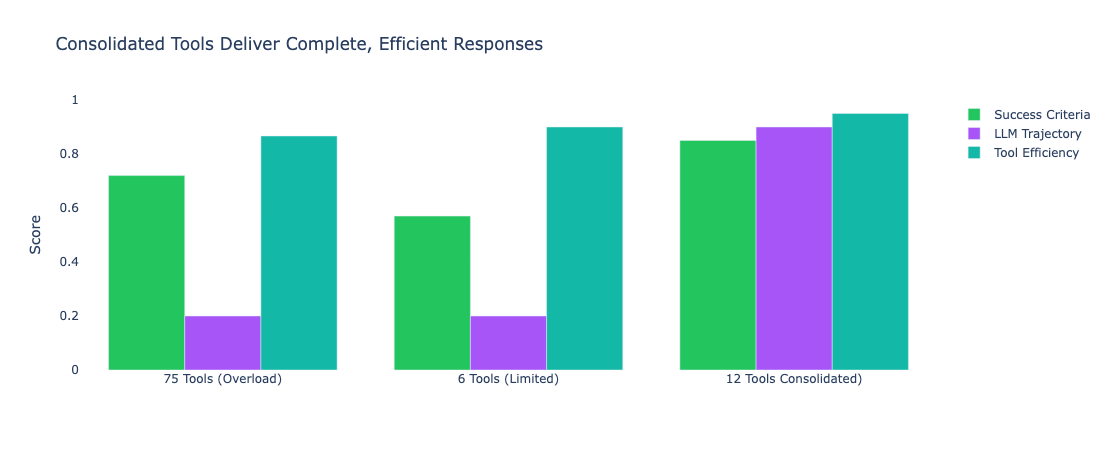

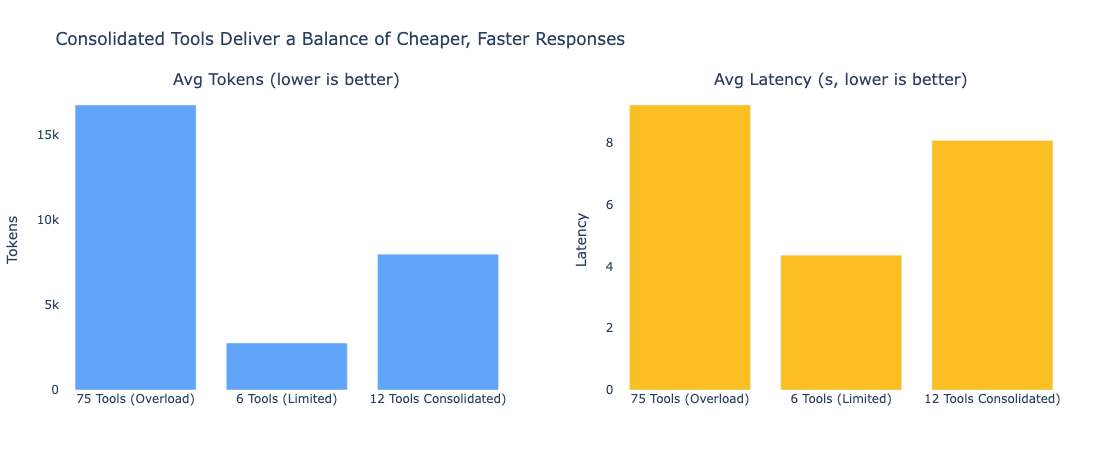

,Configuration,Tool Count,Success Criteria,LLM Trajectory,Tool Efficiency,Avg Latency,Avg Tokens,Avg Cost
0,75 Tools (Overload),75,72.0%,20.0%,0.87,9.23s,16746,$0.0178
1,6 Tools (Limited),6,57.0%,20.0%,0.90,4.37s,2760,$0.0038
2,12 Tools Consolidated),12,85.0%,90.0%,0.95,8.08s,7984,$0.0092



   Key findings: Consolidated tools win across all metrics:
   • Higher success criteria (complete answers)
   • Better tool selection (LLM recognizes appropriate patterns)
   • Improved efficiency (fewer calls, more information)
   • Lower cost: 12-tool agent uses 2.1x fewer tokens than 75-tool agent!


In [19]:
# Comparison visualization showing clear performance wins
configs = ["75 Tools (Overload)", "6 Tools (Limited)", "12 Tools Consolidated)"]
success_scores = [
    production_metrics["success_criteria"],
    minimal_metrics["success_criteria"],
    optimal_metrics["success_criteria"]
]
llm_trajectory_scores = [
    production_metrics["llm_trajectory"],
    minimal_metrics["llm_trajectory"],
    optimal_metrics["llm_trajectory"]
]
efficiency_scores = [
    production_metrics["tool_efficiency"],
    minimal_metrics["tool_efficiency"],
    optimal_metrics["tool_efficiency"]
]
latency_scores = [
    production_metrics["latency"],
    minimal_metrics["latency"],
    optimal_metrics["latency"]
]
token_scores = [
    production_metrics["tokens"],
    minimal_metrics["tokens"],
    optimal_metrics["tokens"]
]
cost_scores = [
    production_metrics["cost"],
    minimal_metrics["cost"],
    optimal_metrics["cost"]
]

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Success Criteria',
    x=configs,
    y=success_scores,
    marker_color='#22c55e'   # Green
))
fig.add_trace(go.Bar(
    name='LLM Trajectory',
    x=configs,
    y=llm_trajectory_scores,
    marker_color='#a855f7'   # Purple
))
fig.add_trace(go.Bar(
    name='Tool Efficiency',
    x=configs,
    y=efficiency_scores,
    marker_color='#14b8a6'   # Teal
))

fig.update_layout(
    title="Consolidated Tools Deliver Complete, Efficient Responses",
    yaxis_title="Score",
    barmode='group',
    height=450,
    showlegend=True,
    yaxis=dict(range=[0, 1.0]),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
)

fig.show()

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    shared_xaxes=False,
    subplot_titles=["Avg Tokens (lower is better)", "Avg Latency (s, lower is better)"],
)

fig.add_trace(go.Bar(
    name="Avg Tokens",
    x=configs,
    y=token_scores,
    marker_color="#60a5fa",
), row=1, col=1)

fig.add_trace(go.Bar(
    name="Avg Latency (s)",
    x=configs,
    y=latency_scores,
    marker_color="#fbbf24",
), row=1, col=2)

fig.update_layout(
    title="Consolidated Tools Deliver a Balance of Cheaper, Faster Responses",
    height=450,
    showlegend=False,
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=60, r=40, t=90, b=60),
)

fig.update_yaxes(title_text="Tokens", row=1, col=1)
fig.update_yaxes(title_text="Latency", row=1, col=2)

fig.show()


# Create summary table with performance metrics
comparison_df = pd.DataFrame({
    "Configuration": configs,
    "Tool Count": [len(all_tools), 6, 12],
    "Success Criteria": [f"{s:.1%}" for s in success_scores],
    "LLM Trajectory": [f"{s:.1%}" for s in llm_trajectory_scores],
    "Tool Efficiency": [f"{s:.2f}" for s in efficiency_scores],
    "Avg Latency": [f"{s:.2f}s" for s in latency_scores],
    "Avg Tokens": [f"{s:.0f}" for s in token_scores],
    "Avg Cost": [f"${s:.4f}" for s in cost_scores],
})

display(comparison_df)

print("\n   Key findings: Consolidated tools win across all metrics:")
print("   • Higher success criteria (complete answers)")
print("   • Better tool selection (LLM recognizes appropriate patterns)")
print("   • Improved efficiency (fewer calls, more information)")
print(f"   • Lower cost: 12-tool agent uses {token_scores[0]/token_scores[2]:.1f}x fewer tokens than 75-tool agent!")

**LangSmith shows us:** Fewer, focused tools perform better than many scattered tools.


---

## Problem 2: Irrelevant Tools Cause Distraction

**Hypothesis:** It's not just quantity - irrelevant tools also cause context confusion.

Test different ratios of relevant:irrelevant tools (total ~20).


In [19]:
# Create noise ratio configurations

noise_configs = [
    {"name": "100-pct-relevant", "tools": consolidated_tools},
    {"name": "50-pct-relevant", "tools": shipping_core_tools + carrier_tools + fraud_tools + analytics_tools},
    {"name": "25-pct-relevant", "tools": shipping_core_tools + fraud_tools + analytics_tools + marketing_tools + vendor_tools},
]

print("Noise ratio configurations:")
for config in noise_configs:
    print(f"  {config['name']}: {len(config['tools'])} total tools")

# Store experiment results
noise_experiments = {}

# Run experiments
for config in noise_configs:
    print(f"\nTesting {config['name']}...")
    
    agent = create_agent(
        model=llm,
        tools=config["tools"],
        system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
    )
    
    experiment_result = evaluate(
        lambda inputs: run_agent_with_trajectory(agent, inputs["query"]),
        data=dataset_name,
        evaluators=ALL_EVALUATORS,
        experiment_prefix=f"noise-{config['name']}",
        metadata={"config": config["name"]},
    )
    
    noise_experiments[config['name']] = experiment_result
    print(f"  Complete")

print("\nAll noise ratio experiments complete!")

Noise ratio configurations:
  100-pct-relevant: 12 total tools
  50-pct-relevant: 15 total tools
  25-pct-relevant: 18 total tools

Testing 100-pct-relevant...
View the evaluation results for experiment: 'noise-100-pct-relevant-7deb0a12' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/3cd88737-30ef-4487-95f7-3a2c0fb9f0aa/compare?selectedSessions=e5c0700f-722a-44d2-8eca-06d6dc45d04b




0it [00:00, ?it/s]

  Complete

Testing 50-pct-relevant...
View the evaluation results for experiment: 'noise-50-pct-relevant-4e25b629' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/3cd88737-30ef-4487-95f7-3a2c0fb9f0aa/compare?selectedSessions=4d2fa61b-55ca-4144-814f-740403351f4d




0it [00:00, ?it/s]

  Complete

Testing 25-pct-relevant...
View the evaluation results for experiment: 'noise-25-pct-relevant-20729f5b' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/3cd88737-30ef-4487-95f7-3a2c0fb9f0aa/compare?selectedSessions=7ad46b7f-4245-4cfd-a92f-3f0f175e631b




0it [00:00, ?it/s]

  Complete

All noise ratio experiments complete!


### Analyzing the Impact of Irrelevant Tools

Let's extract and visualize the results to see how noise affects performance:


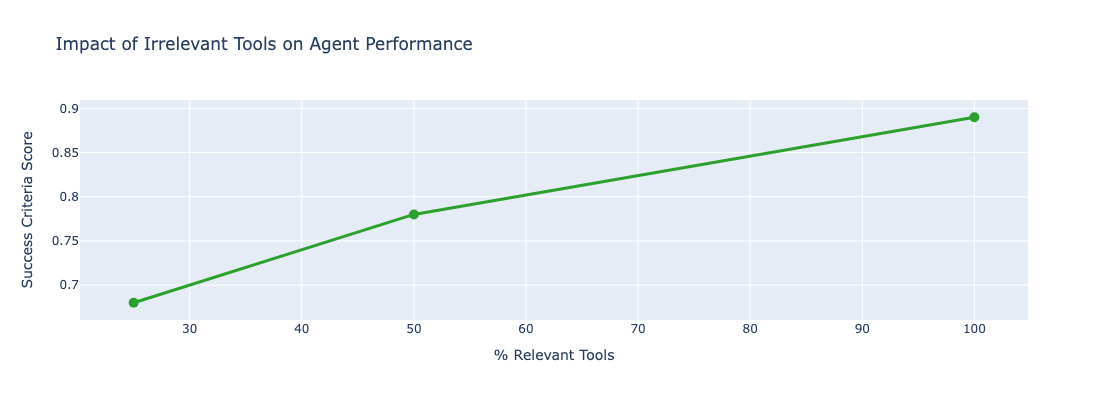

,% Relevant,Success Criteria
0,100,0.89
1,50,0.78
2,25,0.68



Key Findings:
   100% relevant tools: 0.89 success criteria
   25% relevant tools: 0.68 success criteria
   Degradation: 24% drop in success rate
   - Even with constant tool count, noise degrades performance
   - Irrelevant tools lead to incorrect tool calls
   - Quality of tools matters as much as quantity


In [20]:
# Extract metrics from noise ratio experiments
noise_percentages = [100, 50, 25]
noise_configs_names = ["100-pct-relevant", "50-pct-relevant", "25-pct-relevant"]

success_by_noise = []

for config_name in noise_configs_names:
    metrics = get_metrics_from_experiment(noise_experiments[config_name])
    success_by_noise.append(metrics.get("success_criteria", 0))

# Visualize the impact
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=noise_percentages,
    y=success_by_noise,
    mode='lines+markers',
    name='Success Criteria',
    line=dict(color='#2ca02c', width=3),
    marker=dict(size=10),
))

fig.update_layout(
    title="Impact of Irrelevant Tools on Agent Performance",
    xaxis_title="% Relevant Tools",
    yaxis_title="Success Criteria Score",
    hovermode='x unified',
    height=400
)

fig.show()

# Create comparison table
noise_comparison = {
    "% Relevant": noise_percentages,
    "Success Criteria": success_by_noise if success_by_noise[0] > 0 else ["Run eval"] * 3,
}

df_noise = pd.DataFrame(noise_comparison)
display(df_noise)

print("\nKey Findings:")
if success_by_noise[0] > 0:
    print(f"   100% relevant tools: {success_by_noise[0]:.2f} success criteria")
    print(f"   25% relevant tools: {success_by_noise[2]:.2f} success criteria")
    degradation = (
        (success_by_noise[0] - success_by_noise[2])
        / success_by_noise[0] * 100
    )
    print(f"   Degradation: {degradation:.0f}% drop in success rate")
else:
    print("   Run evaluations above to see actual metrics")

print("   - Even with constant tool count, noise degrades performance")
print("   - Irrelevant tools lead to incorrect tool calls")
print("   - Quality of tools matters as much as quantity")

---

## Solution 2: Smart Tool Filtering with Routing

**Insight:** Classify query intent, then provide only relevant tools.


In [ ]:
# Simple query router
def classify_query_intent(query: str) -> Literal["shipping", "returns", "billing", "warehouse"]:
    """Classify intent - in production use an LLM."""
    query_lower = query.lower()
    
    if any(word in query_lower for word in ["return", "refund", "send back"]):
        return "returns"
    elif any(word in query_lower for word in ["bill", "charge", "payment"]):
        return "billing"
    elif any(word in query_lower for word in ["stock", "inventory", "warehouse"]):
        return "warehouse"
    else:
        return "shipping"

def get_tools_for_intent(intent: str) -> list:
    """Return tools for intent."""
    if intent == "shipping":
        return consolidated_tools + carrier_tools
    elif intent == "returns":
        return consolidated_tools + returns_tools
    elif intent == "billing":
        return consolidated_tools + billing_tools
    elif intent == "warehouse":
        return consolidated_tools + warehouse_tools
    return consolidated_tools

print("Created intent-based router")

# Test routed agent
def run_routed_agent_with_trajectory(inputs: dict) -> dict:
    """Run routed agent with intent-based tool selection and return structured output."""
    query = inputs["query"]
    intent = classify_query_intent(query)
    tools = get_tools_for_intent(intent)
    
    agent = create_agent(
        model=llm,
        tools=tools,
        system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
    )
    
    return run_agent_with_trajectory(agent, query)

routed_results = evaluate(
    run_routed_agent_with_trajectory,
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="solution-routed",
    metadata={"config": "routed"},
)

print("\nRouted agent evaluation complete!")


Created intent-based router
View the evaluation results for experiment: 'solution-routed-83edf14b' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/3cd88737-30ef-4487-95f7-3a2c0fb9f0aa/compare?selectedSessions=05bbd203-9003-4a98-8f95-a45bd5b27827




0it [00:00, ?it/s]

### Comparing Routing vs Noise

How does smart routing compare to the worst-case noise scenario?


In [ ]:
# Compare routing solution vs worst noise configuration

worst_noise_metrics = get_metrics_from_experiment(noise_experiments["25-pct-relevant"])
routed_metrics = get_metrics_from_experiment(routed_results)

routing_comparison = {
    "Configuration": ["25% Relevant Tools (No Routing)", "Smart Routing"],
    "LLM Trajectory": [worst_noise_metrics.get("llm_trajectory", 0), routed_metrics.get("llm_trajectory", 0)],
    "Success Criteria": [worst_noise_metrics.get("success_criteria", 0), routed_metrics.get("success_criteria", 0)],
    "Tool Efficiency": [worst_noise_metrics.get("tool_efficiency", 0), routed_metrics.get("tool_efficiency", 0)],
}

# Create bar chart comparison
df_routing = pd.DataFrame(routing_comparison)

fig = go.Figure()
fig.add_trace(go.Bar(
    name='25% Relevant (No Routing)',
    x=['LLM Trajectory', 'Success Criteria'],
    y=[worst_noise_metrics.get("llm_trajectory", 0), worst_noise_metrics.get("success_criteria", 0)],
    marker_color='#d62728'
))
fig.add_trace(go.Bar(
    name='Smart Routing',
    x=['LLM Trajectory', 'Success Criteria'],
    y=[routed_metrics.get("llm_trajectory", 0), routed_metrics.get("success_criteria", 0)],
    marker_color='#2ca02c'
))

fig.update_layout(
    title="Routing Solution vs Worst Noise Configuration",
    yaxis_title="Score",
    barmode='group',
    height=400
)

fig.show()

display(df_routing)

print("\nSmart routing eliminates noise:")
if routed_metrics.get("llm_trajectory", 0) > 0:
    improvement = ((routed_metrics.get("llm_trajectory", 0) - worst_noise_metrics.get("llm_trajectory", 0)) / worst_noise_metrics.get("llm_trajectory", 1) * 100) if worst_noise_metrics.get("llm_trajectory", 0) > 0 else 0
    print(f"   LLM trajectory score improvement: {improvement:.0f}%")
    print(f"   Success criteria improved from {worst_noise_metrics.get('success_criteria', 0):.2f} to {routed_metrics.get('success_criteria', 0):.2f}")
else:
    print("   Run evaluations above to see actual metrics")
print("   - Intent classification filters out irrelevant tool domains")
print("   - Agent sees only tools needed for the query type")
print("   - Maintains performance by keeping context focused")

---

## Problem 3: Instruction Bloat Hurts Too

**Hypothesis:** Verbose instructions degrade performance.

Add evaluator to check instruction following:


In [22]:
# Test with bloated instructions
clean_instructions = SHIPPING_SUPPORT_INSTRUCTIONS
noisy_instructions = SHIPPING_SUPPORT_INSTRUCTIONS + "\n\n" + IRRELEVANT_INSTRUCTIONS

print(f"Clean: {len(clean_instructions):,} chars")
print(f"Noisy: {len(noisy_instructions):,} chars")
print(f"Bloat: {len(noisy_instructions) / len(clean_instructions):.1f}x")

noisy_agent = create_agent(
    model=llm,
    tools=shipping_core_tools,
    system_prompt=noisy_instructions
)

noisy_instruction_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(noisy_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="problem-noisy-instructions",
    metadata={"tool_count": 6, "instruction_length": len(noisy_instructions)},
)

print("Evaluation complete!")

Clean: 707 chars
Noisy: 15,453 chars
Bloat: 21.9x
View the evaluation results for experiment: 'problem-noisy-instructions-dd659d30' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/3cd88737-30ef-4487-95f7-3a2c0fb9f0aa/compare?selectedSessions=3e8ba0ad-51e3-42a9-82d9-09394e2bc787




0it [00:00, ?it/s]

Evaluation complete!


### Analyzing Instruction Bloat Impact

Let's see how extra instructions affected performance:


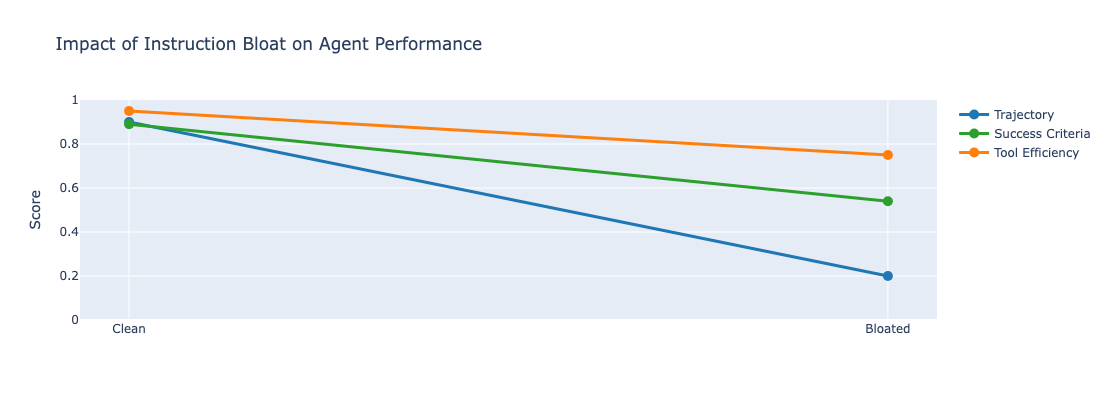

,Metric,Clean Instructions,Bloated Instructions
0,Trajectory,0.90,0.20
1,Success Criteria,0.89,0.54
2,Tool Efficiency,0.95,0.75



Key Findings on Instruction Bloat:
   Trajectory match degraded by 78%
   Success criteria degraded by 39%
   Tool efficiency: 0.75
   - Extra instructions from irrelevant domains confuse the agent
   - Agent may miss obvious tool choices
   - Focused instructions lead to better tool selection


In [28]:
# Extract and compare instruction bloat impact
clean_baseline_metrics = get_metrics_from_experiment(noise_experiments["100-pct-relevant"])
bloated_metrics = get_metrics_from_experiment(noisy_instruction_experiment)

# Create multi-line plot showing metric degradation
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=['Clean', 'Bloated'],
    y=[clean_baseline_metrics.get("llm_trajectory", 0), bloated_metrics.get("llm_trajectory", 0)],
    mode='lines+markers',
    name='Trajectory',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=10)
))

fig.add_trace(go.Scatter(
    x=['Clean', 'Bloated'],
    y=[clean_baseline_metrics.get("success_criteria", 0), bloated_metrics.get("success_criteria", 0)],
    mode='lines+markers',
    name='Success Criteria',
    line=dict(color='#2ca02c', width=3),
    marker=dict(size=10)
))

fig.add_trace(go.Scatter(
    x=['Clean', 'Bloated'],
    y=[clean_baseline_metrics.get("tool_efficiency", 0), bloated_metrics.get("tool_efficiency", 0)],
    mode='lines+markers',
    name='Tool Efficiency',
    line=dict(color='#ff7f0e', width=3),
    marker=dict(size=10)
))

fig.update_layout(
    title="Impact of Instruction Bloat on Agent Performance",
    yaxis_title="Score",
    yaxis=dict(range=[0, 1.0]),
    height=400,
    hovermode='x unified'
)

fig.show()

# Create comparison table
instruction_impact = {
    "Metric": ["Trajectory", "Success Criteria", "Tool Efficiency"],
    "Clean Instructions": [
        f"{clean_baseline_metrics.get('llm_trajectory', 0):.2f}",
        f"{clean_baseline_metrics.get('success_criteria', 0):.2f}",
        f"{clean_baseline_metrics.get('tool_efficiency', 0):.2f}"
    ],
    "Bloated Instructions": [
        f"{bloated_metrics.get('llm_trajectory', 0):.2f}",
        f"{bloated_metrics.get('success_criteria', 0):.2f}",
        f"{bloated_metrics.get('tool_efficiency', 0):.2f}"
    ]
}

df_instructions = pd.DataFrame(instruction_impact)
display(df_instructions)

print("\nKey Findings on Instruction Bloat:")
traj_drop = ((clean_baseline_metrics.get("llm_trajectory", 0) - bloated_metrics.get("llm_trajectory", 0)) / clean_baseline_metrics.get("llm_trajectory", 1) * 100) if clean_baseline_metrics.get("llm_trajectory", 0) > 0 else 0
sc_drop = ((clean_baseline_metrics.get("success_criteria", 0) - bloated_metrics.get("success_criteria", 0)) / clean_baseline_metrics.get("success_criteria", 1) * 100) if clean_baseline_metrics.get("success_criteria", 0) > 0 else 0
print(f"   Trajectory match degraded by {traj_drop:.0f}%")
print(f"   Success criteria degraded by {sc_drop:.0f}%")
print(f"   Tool efficiency: {bloated_metrics.get('tool_efficiency', 0):.2f}")
print("   - Extra instructions from irrelevant domains confuse the agent")
print("   - Agent may miss obvious tool choices")
print("   - Focused instructions lead to better tool selection")

## Solution 3: Instruction Pruning

Keep only relevant instructions in the prompt

---

## Key Takeaways

Our experiments demonstrate a U-curve:

- **75 tools (overload):** Context confusion from overlapping choices leads to poor performance
- **6 tools (minimal):** Over-correction leaves gaps - can't handle all query types
- **12 tools (consolidated):** Sweet spot with flexible parameters delivers full capability AND clarity

**The winning approach:** Intelligent consolidation at the right level of abstraction.

### What Makes Consolidated Tools Work

1. **Flexible parameters over many specific tools** - One `get_order_info` with `include` parameter beats five separate getter functions

2. **Reduces cognitive load** - 12 well-designed tools are easier to navigate than 75 overlapping options

3. **Maintains full capability** - Parameter-based design covers all use cases without sacrificing functionality

4. **Measurable with LangSmith** - Custom evaluators (trajectory match, correctness, efficiency) quantify the improvement

### Professional Implementation Strategy

When facing context confusion in production:

1. **Start with measurement** - Use LangSmith to quantify the problem (don't guess)
2. **Identify tool clusters** - Group tools that serve similar purposes
3. **Design consolidated versions** - Add parameters for flexibility instead of creating new tools
4. **Validate with evals** - Ensure consolidated tools match or exceed original performance
5. **Iterate to sweet spot** - Find the balance between too many and too few

### Real-World Impact
:
- **Better performance** - Higher accuracy, fewer mistakes from tool confusion
- **Lower costs** - Fewer tokens in context, faster inference
- **Easier maintenance** - Consolidated, well-organized toolsets
- **Better UX** - Faster, more accurate responses for users
- **Scalable** - Room to add capabilities without degrading performance


